<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"
alt="Rubin Observatory logo, a graphical representation of turning stars into data."> <br><br>
**Description:** Generate plots and tables summarizing the target fields for the _Rubin Observatory DP1_ paper. <br>
**Authors:** Leanne Guy, Lynne Jones, and Erfan Nourbakhsh <br>
**Last verified to run:** 2025-05-25 <br>
**LSST Science Pipelines version:** v29.0.1<br>
**Container size:** medium <br>

# DP1 target fields summary

The notebook computes statistics and summaries of all the data in the 7 DP1 fields. It computes a number of parameters to beuse din the paper<br>

Tables produced:<br> 
* Table 2: Summary of the DP1 fields.<br>
* Table X: tracts per fields for the datapriducts section <br>

Figures Produced: <br>
* Figure 1: Map of the  DP1 fields superimposed on the survey baseline

## Setup

In [1]:
# Generic python packages
import os
import csv
import requests
import yaml
import numpy as np
import pandas as pd
from pathlib import Path

# LSST Science Pipelines
from lsst.daf.butler import Butler

# RSP
from lsst.rsp import get_tap_service

# Rubin scheduler
from rubin_scheduler.scheduler.utils import get_current_footprint
import healpy as hp

# At the USDF, access the shared rubin_sim data directory
os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

# Set rubin publication plot style
from lsst.utils.plotting import publication_plots, get_multiband_plot_colors
import matplotlib.pyplot as plt
import colorcet as cc
from matplotlib.patches import Patch
from matplotlib.colors import colorConverter, LinearSegmentedColormap
from matplotlib import patheffects
from matplotlib.patches import Ellipse

# Sky projection
import skyproj
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from scipy.ndimage import gaussian_filter
from scipy.interpolate import griddata
from skimage import measure

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

### Install dependencies

In [2]:
# Install the scheduler data if not already done 

# Set the scheduler data path
data_dir = Path('../scheduler_data')
os.environ['RUBIN_SIM_DATA_DIR'] = str(data_dir.resolve())
assert os.getenv('RUBIN_SIM_DATA_DIR') == str(data_dir.resolve())

# Run the install script
%run /opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/bin/scheduler_download_data

Current/updated data versions:
scheduler		scheduler_2023_10_16.tgz
site_models	site_models_2023_10_02.tgz
skybrightness_pre	skybrightness_pre_2024_11_19.tgz
utils		utils_2023_11_02.tgz


### Set publication style

In [3]:
# Setup publication style
publication_plots.set_rubin_plotstyle()
colors = get_multiband_plot_colors()
bands = colors.keys()  # important to get the right order for plot legends
bands_dict = publication_plots.get_band_dicts()
%matplotlib inline

### Define utility functions

In [4]:
# Custom formatter: no trailing zeros if not needed
def custom_float(x):
    if isinstance(x, float):
        s = f"{x:.3f}" #.rstrip('0').rstrip('.')
        return s
    return x

In [5]:
# Function to round to N significant figures
def round_sf(x, sig=3):
    return np.round(x, sig - int(np.floor(np.log10(abs(x)))) - 1)

### Define paths

In [6]:
# Set up the figures, data and tables paths
figures_path = Path('../figures')
tables_path = Path('../tables')

### Set up DP1 Butler

In [7]:
instrument = 'LSSTComCam'
collections = ['LSSTComCam/DP1/defaults', 
               'LSSTComCam/runs/DRP/DP1/v29_0_0/DM-50260',
               'skymaps', ]
skymap = 'lsst_cells_v1'
butler = Butler("/repo/dp1",
                instrument=instrument, 
                collections=collections, 
                skymap=skymap)
registry = butler.registry
skymap = butler.get('skyMap', skymap=skymap)

## Analyse the DP1 target fields 

In [8]:
# Extract filter and pointing information about the fileds from the DP1 exposures in the Butler
exposures = registry.queryDimensionRecords('exposure')
exp_df = pd.DataFrame(columns=['id', 'target', 'physical_filter','ra', 'dec'])
for count, info in enumerate(exposures):
    try:
        exp_df.loc[count] = [info.id, info.target_name, info.physical_filter, 
                         info.tracking_ra, info.tracking_dec,]
    except: 
        print(">>>   Unexpected error:", sys.exc_info()[0])


In [9]:
# Physical filter -> band
exp_df['band'] = exp_df['physical_filter'].str.split('_').str[0]

In [10]:
exp_df

,id,target,physical_filter,ra,dec,band
0,2024110800245,slew_icrs,i_06,53.327236,-28.072055,i
1,2024110800246,slew_icrs,r_03,53.327425,-28.072347,r
2,2024110800247,slew_icrs,r_03,53.141378,-28.131211,r
3,2024110800248,slew_icrs,i_06,53.141304,-28.131213,i
4,2024110800249,slew_icrs,i_06,53.188483,-28.208666,i
...,...,...,...,...,...,...
1787,2024121100607,Seagull,r_03,106.262882,-10.700520,r
1788,2024121100608,Seagull,r_03,106.272920,-10.496384,r
1789,2024121100609,Seagull,r_03,106.360054,-10.420939,r
1790,2024121100610,Seagull,r_03,106.394204,-10.512472,r


## Summarise  the fields

In [11]:
# slew_icrs is the ECDFS field -- combine them
exp_df.loc[exp_df['target'] == 'slew_icrs', 'target'] = 'ECDFS'

In [12]:
# List of unique fields in DP1
dp1_fields = exp_df.target.unique()
assert len(dp1_fields) == 7

In [13]:
# Number of images for each field, total and per band
n_images_all_bands = exp_df.groupby('target').size()
n_images_all_bands = n_images_all_bands.rename('Total').reset_index()

In [14]:
# Compute the number of exposures per band and set the standard band order
n_images_per_band  = exp_df.groupby(['target', 'band']).size().unstack(fill_value=0)[bands]
assert n_images_per_band.to_numpy().sum() == exposures.count()

In [15]:
n_images_summary = pd.merge(n_images_per_band, n_images_all_bands, on='target', how='left')
n_images_summary

,target,u,g,r,i,z,y,Total
0,47_Tuc,6,10,32,19,0,5,72
1,ECDFS,43,230,237,162,153,30,855
2,EDFS_comcam,20,61,87,42,42,20,272
3,Fornax_dSph,0,5,25,12,0,0,42
4,Rubin_SV_095_-25,33,82,84,23,60,10,292
5,Rubin_SV_38_7,0,44,40,55,20,0,159
6,Seagull,10,37,43,0,10,0,100


In [16]:
# Manually insert a description column
n_images_summary.insert(1, 'Field Name',[
    "47 Tucanae Globular Cluster",
    "Extended Chandra Deep Field South",
    "Rubin SV Euclid Deep Field South",
    "Fornax Dwarf Spheroidal Galaxy",
    "Rubin SV Low Galactic Latitude Field",
    "Rubin SV Low Ecliptic Latitude Field",
    "Seagull Nebula"])
n_images_summary

,target,Field Name,u,g,r,i,z,y,Total
0,47_Tuc,47 Tucanae Globular Cluster,6,10,32,19,0,5,72
1,ECDFS,Extended Chandra Deep Field South,43,230,237,162,153,30,855
2,EDFS_comcam,Rubin SV Euclid Deep Field South,20,61,87,42,42,20,272
3,Fornax_dSph,Fornax Dwarf Spheroidal Galaxy,0,5,25,12,0,0,42
4,Rubin_SV_095_-25,Rubin SV Low Galactic Latitude Field,33,82,84,23,60,10,292
5,Rubin_SV_38_7,Rubin SV Low Ecliptic Latitude Field,0,44,40,55,20,0,159
6,Seagull,Seagull Nebula,10,37,43,0,10,0,100


In [17]:
# Compute the median of all pointings per field for the 
# pointing centers and add to the summary table
target_centers = exp_df.groupby('target')[['ra', 'dec']].agg(['median'])
target_centers.columns = ['_'.join(col) for col in target_centers.columns]
target_centers
target_centers = target_centers.map(lambda x: round_sf(x, 4))
dp1_targets_summary = pd.merge(n_images_summary, target_centers, on="target")

In [18]:
dp1_targets_summary

,target,Field Name,u,g,r,i,z,y,Total,ra_median,dec_median
0,47_Tuc,47 Tucanae Globular Cluster,6,10,32,19,0,5,72,6.128,-72.090
1,ECDFS,Extended Chandra Deep Field South,43,230,237,162,153,30,855,53.160,-28.100
2,EDFS_comcam,Rubin SV Euclid Deep Field South,20,61,87,42,42,20,272,59.150,-48.730
3,Fornax_dSph,Fornax Dwarf Spheroidal Galaxy,0,5,25,12,0,0,42,40.080,-34.450
4,Rubin_SV_095_-25,Rubin SV Low Galactic Latitude Field,33,82,84,23,60,10,292,95.040,-25.000
5,Rubin_SV_38_7,Rubin SV Low Ecliptic Latitude Field,0,44,40,55,20,0,159,37.980,7.015
6,Seagull,Seagull Nebula,10,37,43,0,10,0,100,106.300,-10.510


In [19]:
# Rename and reorder 
dp1_targets_summary.rename(columns={
    'target': "Field Code",
    'ra_median': 'RA',
    'dec_median': 'DEC'}, inplace=True)

# Reorder columns by specifying the new order
dp1_targets_summary.insert(2, 'RA', dp1_targets_summary.pop('RA'))
dp1_targets_summary.insert(3, 'DEC', dp1_targets_summary.pop('DEC'))


In [20]:
# Format the date to produce a latex table
# Insert blank colum for nice spacing in table 
dp1_targets_summary.insert(4, ' ', ' ')

# Escape the underscores in the field names and codes
dp1_targets_summary.columns = dp1_targets_summary.columns.str.replace('_', r'\_', regex=False)
dp1_targets_summary = dp1_targets_summary.map(lambda x: x.replace('_', r'\_') if isinstance(x, str) else x)

dp1_targets_summary_latex = dp1_targets_summary.to_latex(index=False, 
                                                         escape=False, 
                                                         bold_rows=False,
                            formatters={col: custom_float 
                                        for col in dp1_targets_summary.columns}
                            )

# Remove unnecessary latex
data_latex = dp1_targets_summary_latex.split("midrule\n", 1)[-1]  # Keeps the part after 'midrule'
data_latex = data_latex.split("\\bottomrule", 1)[0]  # Keeps the part before 'bottomrule'

In [21]:
dp1_targets_summary

,Field Code,Field Name,RA,DEC,,u,g,r,i,z,y,Total
0,47\_Tuc,47 Tucanae Globular Cluster,6.128,-72.090,,6,10,32,19,0,5,72
1,ECDFS,Extended Chandra Deep Field South,53.160,-28.100,,43,230,237,162,153,30,855
2,EDFS\_comcam,Rubin SV Euclid Deep Field South,59.150,-48.730,,20,61,87,42,42,20,272
3,Fornax\_dSph,Fornax Dwarf Spheroidal Galaxy,40.080,-34.450,,0,5,25,12,0,0,42
4,Rubin\_SV\_095\_-25,Rubin SV Low Galactic Latitude Field,95.040,-25.000,,33,82,84,23,60,10,292
5,Rubin\_SV\_38\_7,Rubin SV Low Ecliptic Latitude Field,37.980,7.015,,0,44,40,55,20,0,159
6,Seagull,Seagull Nebula,106.300,-10.510,,10,37,43,0,10,0,100


In [22]:
# Export to latex with deulxetable formatting 
filename = tables_path/ "dp1_fields_summary.tex"
with open(filename, "w") as f:
    f.write(r"""%%%%% This table is auto generated from data, DO NOT EDIT
\begin{deluxetable}{llcccp{0.5cm}p{0.6cm}p{0.3cm}p{0.3cm}p{0.3cm}p{0.3cm}r}
\caption{DP1 fields and pointing centers with the number of images in each band per field.  
ICRS coordinates are in units of decimal degrees. 
\label{tab:dp1_fields} }
\tablehead{
  \colhead{\textbf{Field Code}} & \colhead{\textbf{Field Name}} & \colhead{\textbf{RA}} & \colhead{\textbf{DEC}} 
  & & \multicolumn{6}{c}{\textbf{Band}} & \colhead{\textbf{Total}}\\
  \cline{3-4} \cline{6-11} 
  & & \colhead{deg}  & \colhead{deg}  & & u & g & r & i & z & y & 
}
\startdata
""")
    f.write(data_latex)
    f.write(r"""\enddata
\end{deluxetable}
""")
f.close()

## Figure showing DP1 fields with baseline survey areas in background

In [23]:
# Survey footprint
fp_nside = 512
footprint_hp, labels = get_current_footprint(nside=fp_nside)
np.unique(labels)

array(['', 'LMC_SMC', 'bulgy', 'dusty_plane', 'euclid_overlap', 'lowdust',
       'nes', 'scp', 'virgo'], dtype='<U20')

In [24]:
# Make a colormap and normalization
region_dict = {'scp': 0, 'nes': 1, 'dusty_plane': 2, 'gpwfd': 3, 'lowdust': 4} 
colorlist = ['#ECE133', '#CC78BC', '#CA9161', '#029E73', '#56B4E9']
mpl_colors = []
for color in colorlist:
    mpl_colors.append(colorConverter.to_rgb(color))
cmap = LinearSegmentedColormap.from_list(colorlist, mpl_colors)
norm = plt.Normalize(vmin=0, vmax=max(region_dict.values()))

In [25]:
max(region_dict.values())

4

In [26]:
# Plot 
total_fp = np.zeros(len(labels))
total_fp = np.where(labels == 'scp', region_dict['scp'], total_fp)
total_fp = np.where(labels == 'nes', region_dict['nes'], total_fp)
total_fp = np.where((labels == 'dusty_plane'), region_dict['dusty_plane'], total_fp)
total_fp = np.where(((labels == 'bulgy') | (labels == 'LMC_SMC')), region_dict['gpwfd'], total_fp)
total_fp = np.where(((labels == 'euclid_overlap') | (labels == 'lowdust') | (labels == 'virgo')), region_dict['lowdust'], total_fp)
total_fp = np.where(labels == '', np.nan, total_fp)

### Utility functions to enhance the field + survey area visualization

In [27]:
def skyproj_to_imshow_args(
    sp, lon, lat, values, width=800, height=None, method="nearest", fill_value=-np.inf
):
    """Convert sky projection data to an image format suitable for matplotlib's imshow.

    Projects and interpolates skyproj projection onto a regular grid while properly
    handling masked values and projection boundaries.

    Parameters
    ----------
    sp : skyproj.Skyproj
        SkyProj projection object (e.g., McBrydeSkyproj or MollweideSkyproj object).
    lon, lat : ndarray or MaskedArray
        2D array of rasterized longitude and latitude grid vertices with shape = (n, n).
    values : ndarray or MaskedArray
        Masked array of rasterized values with shape = (n-1, n-1) compared to lon/lat.
    width : int, optional
        Width of output image in pixels. Default is 800.
    height : int, optional
        Height of output image in pixels. Default is width // 2.
    method : str, optional
        Interpolation method for `griddata`. Default is 'nearest'.
    fill_value : float, optional
        Fill value for masked-out regions. Default is -np.inf.

    Returns
    -------
    img_ma : MaskedArray
        2D image for plotting via `imshow`.
    extent : tuple
        Extent tuple (xmin, xmax, ymin, ymax) for correct imshow placement.
    """
    if height is None:
        height = width // 2

    # Project the input longitude/latitude vertex grid.
    Xv, Yv = sp.proj(lon, lat)

    # Compute cell centers from surrounding vertices.
    Xc = 0.25 * (Xv[:-1, :-1] + Xv[1:, :-1] + Xv[:-1, 1:] + Xv[1:, 1:])
    Yc = 0.25 * (Yv[:-1, :-1] + Yv[1:, :-1] + Yv[:-1, 1:] + Yv[1:, 1:])

    # Flatten center points and values.
    xc, yc = Xc.ravel(), Yc.ravel()
    values_arr = np.array(values)
    if np.ma.is_masked(values):
        z = values.ravel()
        mask_in = values.mask.ravel() | ~np.isfinite(z)
    else:
        z = values_arr.ravel()
        mask_in = ~np.isfinite(z)

    valid = ~mask_in
    pts = np.column_stack((xc[valid], yc[valid]))
    vals = z[valid]

    # Build output grid.
    xmin, xmax = Xv.min(), Xv.max()
    ymin, ymax = Yv.min(), Yv.max()
    xi = np.linspace(xmin, xmax, width)
    yi = np.linspace(ymin, ymax, height)
    XI, YI = np.meshgrid(xi, yi)

    # Interpolate onto regular grid.
    img = griddata(pts, vals, (XI, YI), method=method, fill_value=fill_value)

    # Identify truly projectable points, meaning they were genuinely on
    # the valid globe surface (inspired by SkyProj’s _get_boundary_poly_xy).
    # https://github.com/LSSTDESC/skyproj/blob/770adfe52ef4eb9185f4fdf094ecbf47bf0670ae/skyproj/utils.py#L96C1-L102C55
    # The goal is only to keep pixels whose coordinates round-trip accurately, i.e.,
    # inverse projection followed by forward projection returns them to the same spot.
    # This is needed to exclude areas outside the valid projection region in
    # projections like McBryde.
    lon2, lat2 = sp.proj_inverse(XI, YI)  # back to lon/lat.
    Xr, Yr = sp.proj(lon2, lat2)  # reproject to see if consistent.
    inside = np.isclose(Xr, XI) & np.isclose(Yr, YI)
    outside = ~inside

    # Mask propagation from input map to grid.
    mask_vals = (~mask_in).astype(float)
    mask_grid = griddata(np.column_stack((xc, yc)), mask_vals, (XI, YI), method=method, fill_value=0.0) == 0.0

    combined_mask = outside | mask_grid
    img_ma = np.ma.MaskedArray(img, mask=combined_mask, fill_value=fill_value)

    return img_ma, (xmin, xmax, ymin, ymax)


def add_outlined_text(
    ax,
    x,
    y,
    text,
    fontsize=9,
    text_color="black",
    text_alpha=0.75,
    outline_color="white",
    outline_alpha=0.65,
    outline_width=2,
    background_alpha=0.29,
    background_color="white",
    loc="bottom left",
    **kwargs,
):
    """Add text with an outline and semi-transparent background."""
    va, ha = loc.split(" ")
    vsign = 1 if va == "bottom" else -1
    hsign = 1 if ha == "left" else -1

    t = ax.annotate(
        text,
        (x, y),
        fontsize=fontsize,
        color=text_color,
        alpha=text_alpha,
        va=va,
        ha=ha,
        xytext=(3.4 * hsign, 3.4 * vsign),
        textcoords="offset points",
        bbox=dict(
            facecolor=background_color,
            alpha=background_alpha,
            edgecolor="none",
            boxstyle="round,pad=0.22,rounding_size=0.45",
        ),
        **kwargs,
    )

    t.set_path_effects(
        [
            patheffects.Stroke(linewidth=outline_width, foreground=outline_color, alpha=outline_alpha),
            patheffects.Normal(),
        ]
    )

    return t


def nside_to_pixel_radec(nside, galactic_pixel_coords=False, nest=True):
    """Get RA/Dec (deg) of every HEALPix pixel center.

    Parameters
    ----------
    nside : int
        HEALPix NSIDE.
    galactic_pixel_coords : bool, optional
        If True, pix2ang’s lon/lat are Galactic l,b and will be
        converted to ICRS RA/Dec. If False (default), they’re taken
        directly as RA/Dec.
    nest : bool, optional
        True for NESTED ordering, False for RING (default True).

    Returns
    -------
    ra, dec : ndarray
        Pixel center coordinates in ICRS, in degrees.
    """
    npix = hp.nside2npix(nside)
    lon, lat = hp.pix2ang(nside, np.arange(npix), nest=nest, lonlat=True)
    if galactic_pixel_coords:
        gal = SkyCoord(l=lon * u.deg, b=lat * u.deg, frame="galactic")
        ra, dec = gal.icrs.ra.deg, gal.icrs.dec.deg
    else:
        ra, dec = lon, lat
    return ra, dec


def load_milkyway_dustmap(filename="lambda_fds_dust_94GHz.fits", nest=True):
    """Load and transform Milky Way dust map from Galactic to Equatorial coordinates,
    filling any missing pixels via nearest-neighbor interpolation.

    The default map is downloaded from:
    https://lambda.gsfc.nasa.gov/product/foreground/fg_fds_get.html
    Model Dust Map (Finkbeiner, Davis & Schlegel)
    Delivery Date: 2010-11-14

    Parameters:
    -----------
    filename : str, optional
        Path to FITS file containing the dust map (default: "lambda_fds_dust_94GHz.fits")
    nest: bool, optional
        Map in nest ordering?

    Returns:
    --------
    equatorial_mw_map: numpy.ndarray
        The transformed map in Equatorial coordinates (HEALPix nested scheme).
    """
    # Load Milky Way data as a HEALPix map (in Galactic coords)
    # Model Dust Map (Finkbeiner, Davis & Schlegel)
    with fits.open(filename, mode="readonly") as hdu:
        mw_data = hdu[1].data["TEMPERATURE"]

    npix = len(mw_data)
    nside = hp.npix2nside(npix)
    ra, dec = nside_to_pixel_radec(nside, galactic_pixel_coords=True, nest=nest)

    # Convert to HEALPix spherical coordinates.
    theta_eq = np.radians(90 - dec)
    phi_eq = np.radians(ra)

    # Remap the original MW values onto the equatorial HEALPix grid.
    equatorial_mw_map = np.full_like(mw_data, hp.UNSEEN)
    remapped_pix = hp.ang2pix(nside, theta_eq, phi_eq, nest=nest)
    equatorial_mw_map[remapped_pix] = mw_data

    # Interpolate values for missing (UNSEEN) pixels.
    valid_pixels = equatorial_mw_map != hp.UNSEEN
    if np.any(~valid_pixels):  # Only interpolate if there are missing pixels.
        print(f"Interpolating values for {sum(~valid_pixels)} missing pixels in your Milky Way dust map...")
        interp_values = griddata(
            points=np.column_stack((theta_eq[valid_pixels], phi_eq[valid_pixels])),
            values=equatorial_mw_map[valid_pixels],
            xi=np.column_stack((theta_eq[~valid_pixels], phi_eq[~valid_pixels])),
            method="nearest",
        )
        equatorial_mw_map[~valid_pixels] = interp_values

    return equatorial_mw_map


def draw_region_outline(
    sp,
    im,
    extent,
    levels=(0.5, 1, 2, 3, 4),
    stroke=False,
    color="black",
    stroke_color="white",
    zorder=15,
    sigma=1.5,
    linewidth=1.0,
    strokewidth=1.5,
    alpha=0.7,
    stroke_alpha=0.7,
):
    """Draw contours from a masked image array (e.g. from `skyproj_to_imshow_args`).

    Combines:
      1. Value-based contours (for internal structure)
      2. Mask edge tracing (to recover missing outlines)

    Parameters
    ----------
    sp : skyproj.BaseSkyproj
        SkyProj object to draw on.
    im : np.ma.MaskedArray
        Masked array used with imshow.
    extent : tuple
        Image extent used with imshow (xmin, xmax, ymin, ymax).
    levels : list or tuple
        Contour levels to draw (passed to matplotlib).
    stroke : bool
        Add outline stroke for contrast.
    color: str
        Color of the outline drawn.
    stroke_color: str
        Color of the outline stroke.
    zorder : int
        Z-order of drawn lines.
    sigma : float
        Smoothing for mask-based edge detection.
    linewidth: float
        Line width of the outline drawn.
    strokewidth: float
        Line width of the outline stroke.
    alpha: float
        Transparency of the outline drawn.
    stroke_alpha: float
        Transparency of the outline stroke.
    """
    # Draw matplotlib contours (value-based).
    cs = sp.ax.contour(
        im,
        levels=levels,
        extent=extent,
        colors=color,
        linewidths=linewidth,
        linestyles="-",
        zorder=zorder,
        alpha=alpha,
    )

    # Add white stroke for visibility.
    if stroke:
        cs.set_path_effects(
            [
                patheffects.Stroke(linewidth=strokewidth, foreground=stroke_color, alpha=stroke_alpha),
                patheffects.Normal(),
            ]
        )

    # Recover outlines from mask (for projections with missing edge lines).
    # Use the mask of im to detect edges.
    mask = ~(im.mask | np.isnan(im))
    blurred = gaussian_filter(mask.astype(float), sigma=sigma)

    # Get contours at the 0.5 level.
    outlines = measure.find_contours(blurred, 0.5)

    for seg in outlines:
        x_pix, y_pix = seg[:, 1].astype(int), seg[:, 0].astype(int)

        # Convert pixel coordinates to projection space.
        x = extent[0] + x_pix / im.shape[1] * (extent[1] - extent[0])
        y = extent[2] + y_pix / im.shape[0] * (extent[3] - extent[2])

        # Convert to lon/lat.
        lon, lat = sp.proj_inverse(x, y)
        keep = np.isfinite(lon) & np.isfinite(lat)

        # Draw with twice the alpha to appear similar to the value-based
        # contours that were drawn on top of each other.
        (line,) = sp.plot(
            lon[keep], lat[keep], "-", color=color, lw=linewidth, zorder=zorder + 1, alpha=2 * alpha
        )

        # Add white stroke for visibility.
        if stroke:
            line.set_path_effects(
                [
                    patheffects.Stroke(
                        linewidth=strokewidth, foreground=stroke_color, alpha=2 * stroke_alpha
                    ),
                    patheffects.Normal(),
                ]
            )

### Enhanced visualization

Interpolating values for 394726 missing pixels in your Milky Way dust map...


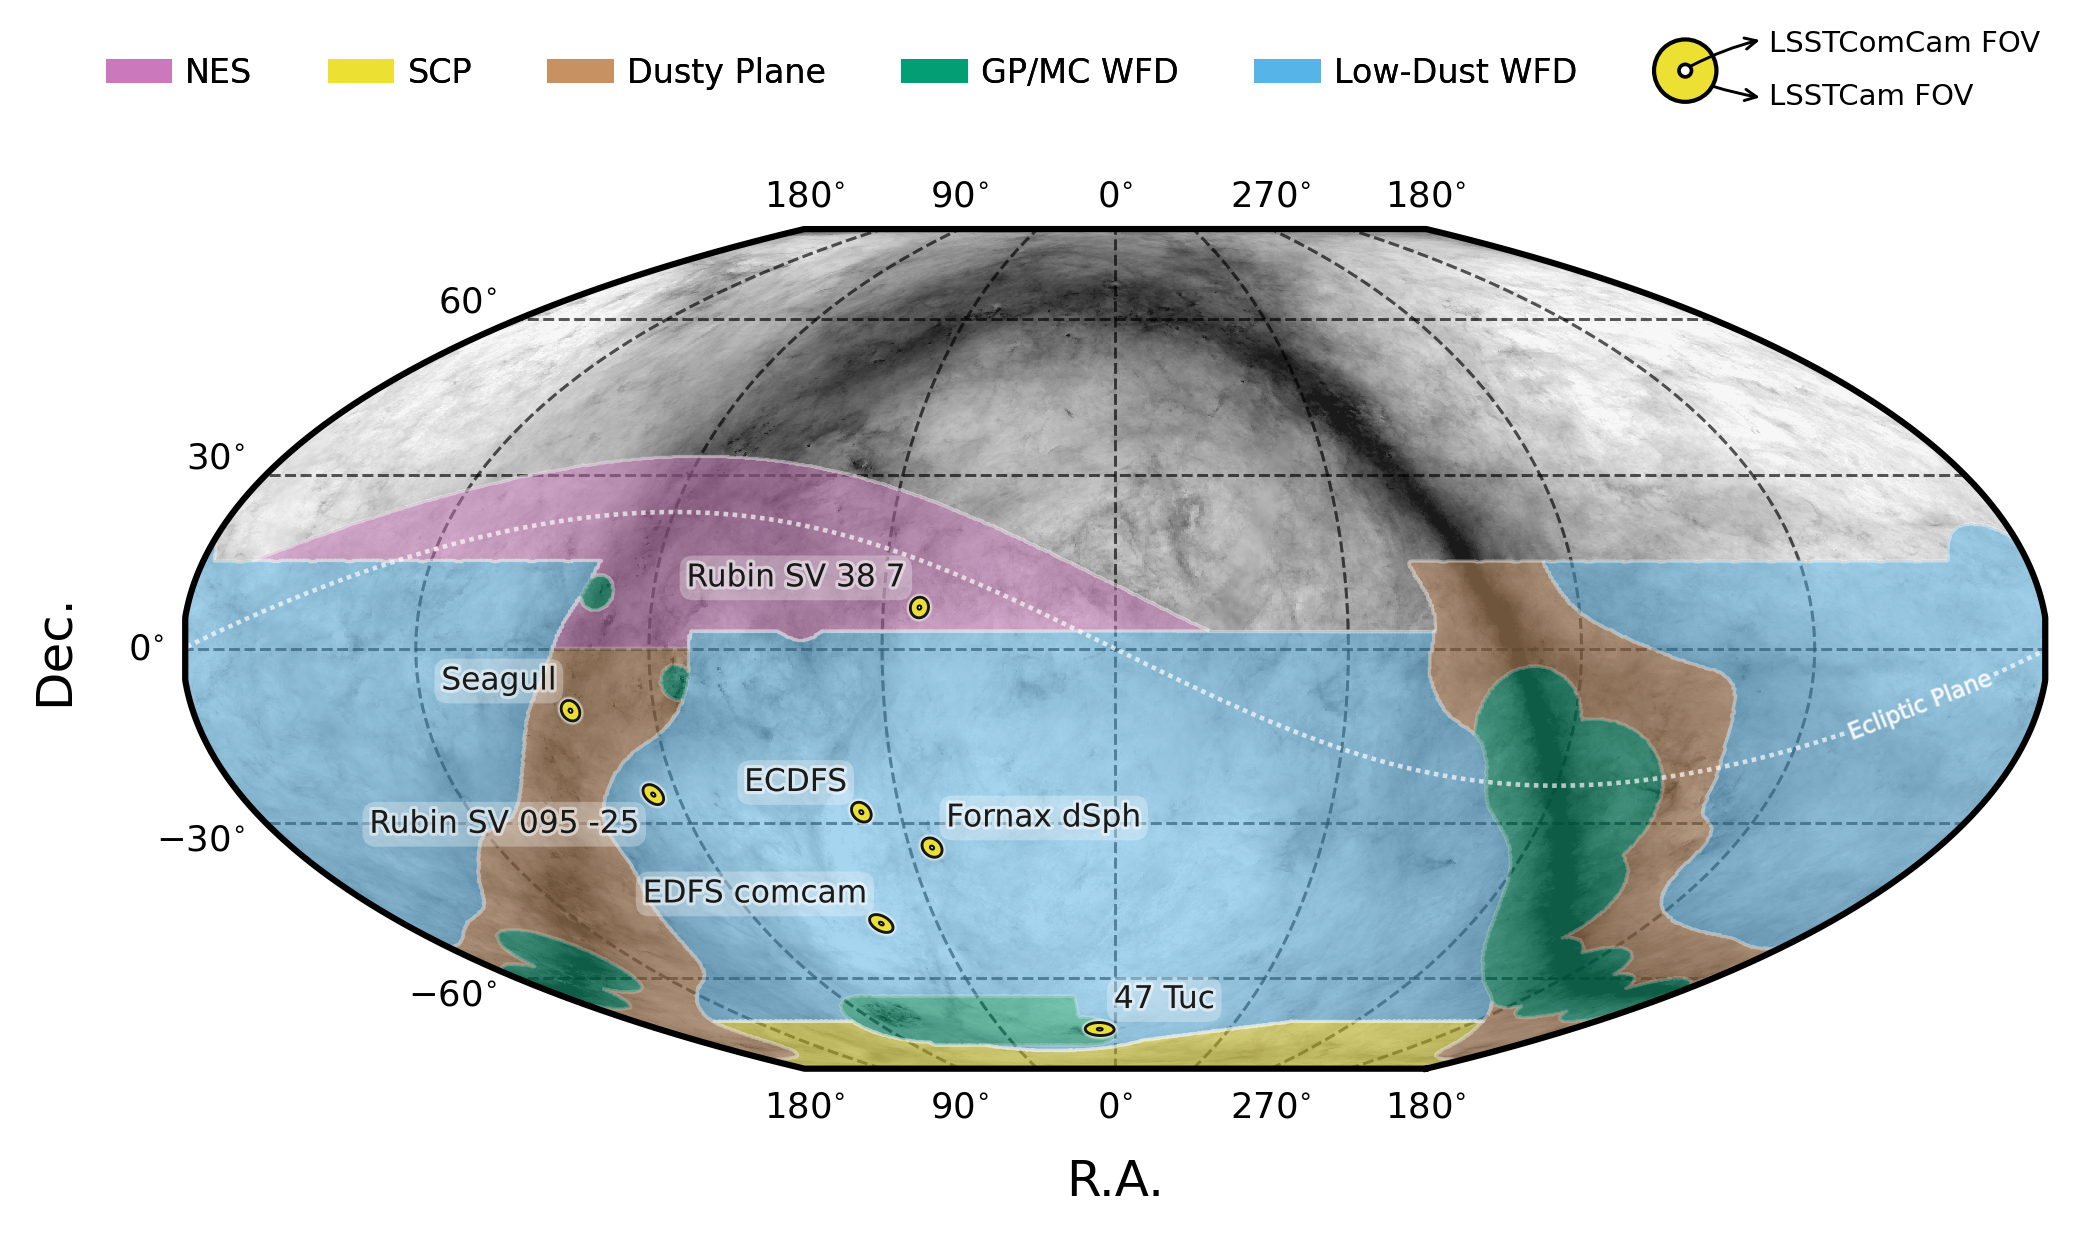

In [28]:
# Compute points along the ecliptic and draw it as a projected line.
draw_ecliptic_plane = True

# Draw model dust map of the Milky Way Galaxy in the background.
draw_milky_way_dustmap = True

# Represent the Milky Way Galaxy by plotting a thick line along the
# Galactic equator, and two dashed lines at +/- 10 degrees.
draw_milky_way_lines = False

# Use projected camera FOV as markers to show targets.
# If False, it uses simple black circles.
fov_markers = True

# Fill in three tiny gaps that show up along the GP-lowdust WFD boundary when
# fp_nside >= 128. These gaps result from defining galactic WFD regions using
# circles — which is what we see as "blobs" near Seagull. However, they're not
# real in terms of actual use - the scheduler only ever runs at nside=32 for
# very good reasons (including that the main camera's FOV is 3.5 degrees),
# where these gaps don't actually materialize.
fix_gap_boundaries = True

# Set to True to add yellow dashed lines at GP/WFD boundaries used
# to recolor three tiny gaps that appear with fp_ndide >= 128 with
# more GP WFD coverage.
draw_gap_fixup_polygon = False

# Field of view of the cameras in degrees.
LSSTCam_FOV = 3.5
LSSTComCam_FOV = 0.7

# Define the zones for the gap fixup in the form of list[(ra_range, dec_range)].
fixup_radec_ranges = [([275, 290], [-30, -17]), ([232, 260], [-65.23, -55])]

# Make a copy of the footprint data, in case we decide to fix it.
total_fp_materialized = total_fp.copy()

# Create a figure.
fig, ax = plt.subplots(figsize=(8, 6))
rcparams = {"axes.linewidth": 1.5, "xtick.labelsize": 8.5, "ytick.labelsize": 8.5}

with plt.rc_context(rcparams):
    sp = skyproj.McBrydeSkyproj(
        ax=ax,
        celestial=True,
        galactic=False,
        gridlines=True,
        n_grid_lon=6,
        n_grid_lat=5,
        min_lon_ticklabel_delta=0.05,
    )

sp.ax.set_xlabel("R.A.", fontsize=12, labelpad=9)
sp.ax.set_ylabel("Dec.", fontsize=12, labelpad=12)

if draw_milky_way_dustmap:
    mw_map = load_milkyway_dustmap(filename="lambda_fds_dust_94GHz.fits", nest=True)

    # Define a faint gray colormap.
    faint_gray = LinearSegmentedColormap.from_list(
        "gray_r",
        [
            (0.0, (0.97, 0.97, 0.97)),  # very light gray (not white)
            (1.0, (0.1, 0.1, 0.1)),  # medium-dark gray
        ],
        N=800,
    )

    # Draw in RA/Dec with skyproj.
    vmin, vmax = np.nanquantile(np.log(mw_map), (0.01, 0.99))
    sp.draw_hpxmap(
        np.log(mw_map), cmap=faint_gray, shading="auto", nest=True, vmin=vmin, vmax=vmax, zoom=False
    )

if draw_milky_way_lines:
    sp.draw_milky_way(label="Milky Way")

if fix_gap_boundaries:
    ra, dec = nside_to_pixel_radec(fp_nside, nest=False)
    for (ra0, ra1), (dec0, dec1) in fixup_radec_ranges:
        (idx,) = np.where(
            (total_fp == region_dict["dusty_plane"]) & (ra > ra0) & (ra < ra1) & (dec > dec0) & (dec < dec1)
        )
        # Add more GP WFD coverage to fill gaps in the area.
        total_fp_materialized[idx] = region_dict["gpwfd"]

mesh, lon_raster, lat_raster, values_raster = sp.draw_hpxmap(
    total_fp_materialized, cmap=cmap, norm=norm, nest=False, zoom=False, zorder=1.5
)

# Need to remove the mesh layer here as it suffers from ripple-like/Moiré-like
# artifacts when using alpha < 1. These unwanted overlaps are due to
# transparency + HEALPix projection + many small quads. We will redraw
# it after passing it through `skyproj_to_imshow_args` to fix the issue.
mesh.remove()

legend_handles_1 = [
    Patch(facecolor=cmap(norm(region_dict["nes"])), label="NES"),
    Patch(facecolor=cmap(norm(region_dict["scp"])), label="SCP"),
    Patch(facecolor=cmap(norm(region_dict["dusty_plane"])), label="Dusty Plane"),
    Patch(facecolor=cmap(norm(region_dict["gpwfd"])), label="GP/MC WFD"),
    Patch(facecolor=cmap(norm(region_dict["lowdust"])), label="Low-Dust WFD"),
]

legend_xoffset = -0.05 if fov_markers else 0.065
legend_yoffset = 1.15
legend1 = sp.ax.legend(
    handles=legend_handles_1,
    loc=(legend_xoffset, legend_yoffset),
    fontsize=8,
    ncols=5,
    columnspacing=2.26,
    handletextpad=0.39,
    frameon=False,
)

# Attach the legend(s) at the figure level. Note that sp.ax.add_artist() won’t work!
fig.add_artist(legend1)

if fov_markers:
    # Pick a spot in FIGURE‐fraction coords.
    bbox = sp.ax.get_position()
    x0 = bbox.x1 - 0.15
    y0 = bbox.y1 + 0.088

    # Pick a fraction‐width for the big radius.
    r_frac = 0.013

    # Compute fig aspect ratio.
    fig_w, fig_h = fig.get_size_inches()
    aspect = fig_w / fig_h

    # Draw ellipses that will show up as perfect circles
    # after the plot is rendered.
    outer = Ellipse(
        (x0, y0),
        width=2 * r_frac,
        height=2 * r_frac * aspect,
        transform=fig.transFigure,
        facecolor=colorConverter.to_rgba("#ECE133", 0.9),
        edgecolor="black",
        linewidth=1.0,
        alpha=1,
        zorder=-1,
    )
    inner = Ellipse(
        (x0, y0),
        width=2 * (r_frac * (LSSTComCam_FOV / LSSTCam_FOV)),
        height=2 * (r_frac * (LSSTComCam_FOV / LSSTCam_FOV)) * aspect,
        transform=fig.transFigure,
        facecolor="white",
        edgecolor="black",
        linewidth=0.88,
        alpha=1,
    )

    fig.add_artist(outer)
    fig.add_artist(inner)

    sp.ax.annotate(
        "LSSTComCam FOV",
        xy=(x0, y0 + 0.07 * r_frac),
        xycoords=fig.transFigure,
        xytext=(x0 + 0.035, y0 + 1.16 * r_frac),
        textcoords=fig.transFigure,
        arrowprops=dict(
            arrowstyle="<-,head_length=0.35,head_width=0.17",
            linestyle="-",
            color="black",
            linewidth=0.7,
            connectionstyle="arc3,rad=0.2",
            shrinkA=0.25,
            shrinkB=1.5,
            mutation_scale=8,  # Size of arrowhead
            mutation_aspect=1,  # Keeps arrowhead proportions (1 = square aspect)
            alpha=1,
        ),
        ha="left",
        va="center",
        fontsize=7,
        annotation_clip=False,
    )

    sp.ax.annotate(
        "LSSTCam FOV",
        xy=(x0 + 0.5 * r_frac, y0 - 0.5 * r_frac),
        xycoords=fig.transFigure,
        xytext=(x0 + 0.035, y0 - 1.1 * r_frac),
        textcoords=fig.transFigure,
        arrowprops=dict(
            arrowstyle="<-,head_length=0.35,head_width=0.17",
            linestyle="-",
            color="black",
            linewidth=0.7,
            connectionstyle="arc3,rad=-0.13",
            shrinkA=0.25,
            shrinkB=3,
            mutation_scale=8,
            mutation_aspect=1,
            alpha=1,
        ),
        ha="left",
        va="center",
        fontsize=7,
    )

sp.ax.gridlines.set_edgecolor("black")
sp.ax.gridlines.set_linewidth(0.7)
sp.ax.gridlines.set_linestyle("--")
sp.ax.gridlines.set_alpha(0.19)
sp.ax.gridlines.zorder = 1

for i, target in dp1_targets_summary.iterrows():
    name = target["Field Code"].replace("\\", "").replace("_", " ")
    length = len(name)
    if fov_markers:
        (c,) = sp.circle(
            target.RA,
            target.DEC,
            LSSTCam_FOV / 2,
            nsamp=200,
            label="LSSTCam FOV",
            fill=True,
            facecolor=colorConverter.to_rgba("#ECE133", 0.9),
            edgecolor="black",
            linewidth=0.7,
            alpha=0.9,
            zorder=14,
        )
        sp.circle(
            target.RA,
            target.DEC,
            LSSTComCam_FOV / 2,
            nsamp=200,
            label="LSSTComCam FOV",
            fill=True,
            color="white",
            edgecolor="black",
            linewidth=0.5,
            alpha=0.95,
            zorder=14.5,
        )
        c.set_path_effects(
            [
                patheffects.Stroke(linewidth=2, foreground="white", alpha=0.25),  # The white outline #1
                patheffects.Stroke(linewidth=1.5, foreground="white", alpha=0.35),  # The white outline #2
                patheffects.Stroke(linewidth=1, foreground="white", alpha=0.5),  # The white outline #3
                patheffects.Normal(),  # Then draw the original
            ]
        )
    else:
        sp.plot(
            target.RA,
            target.DEC,
            marker=".",
            markerfacecolor="black",
            markeredgewidth=0.5,
            markeredgecolor="lightgrey",
            markersize=11,
            alpha=0.7,
            zorder=14,
        )
    x, y = sp.proj(target.RA, target.DEC)
    loc = "bottom left"
    if name == "Rubin SV 095 -25":
        loc = "top right"
    elif name in ["ECDFS", "EDFS comcam"]:
        loc = "bottom right"
    elif name in ["Seagull", "Rubin SV 38 7"]:
        loc = "bottom right"
    add_outlined_text(
        sp.ax,
        x,
        y,
        name,
        loc=loc,
        fontsize=7.5,
        outline_width=1.5,
        text_alpha=0.85,
        background_alpha=0.3,
        outline_alpha=0.5,
        zorder=14,
    )

if draw_ecliptic_plane:
    # Ecliptic longitude (0–360), latitude=0.
    ecl_lon = np.linspace(0, 360, 1000)
    ecl_lat = np.zeros_like(ecl_lon)

    # Convert to RA/Dec.
    ecl_eq = SkyCoord(ecl_lon * u.deg, ecl_lat * u.deg, frame="geocentrictrueecliptic").transform_to("icrs")
    ecl_ra = ecl_eq.ra.deg
    ecl_dec = ecl_eq.dec.deg

    # Choose a point index along the line with an optional offset in Dec.
    ra_label = 203.3
    dec_offset = 0
    idx = np.argmin(np.abs(ecl_ra - ra_label))

    # Get projected screen coordinates from skyproj.
    (xi, yi), (xf, yf) = [
        tuple(map(lambda a: a[0], sp.proj(ecl_ra[j], ecl_dec[j]))) for j in [idx - 1, idx + 1]
    ]

    # Get local tangent angle in screen space.
    dx = xf - xi
    dy = yf - yi
    angle = np.degrees(np.arctan2(dy, dx))

    # Plot the text slightly above the line.
    sp.ax.text(
        ecl_ra[idx],
        ecl_dec[idx] + dec_offset,
        "Ecliptic Plane",
        color="white",
        fontsize=5.5,
        alpha=0.74,
        ha="center",
        va="center",
        rotation=360 - angle,
        rotation_mode="anchor",
        path_effects=[
            patheffects.Stroke(linewidth=0.45, foreground="white", alpha=0.4),
            patheffects.Normal(),
        ],
        zorder=14,
    )

    # Plot ecliptic line while leaving a gap under text.
    # Geodesic lines wrap in projection space, so we must explicitly handle
    # that for Matplotlib.
    gap_deg = 13.0  # Adjust based on the label length.
    gap = (ecl_ra > (ecl_ra[idx] - gap_deg)) & (ecl_ra < (ecl_ra[idx] + gap_deg))
    ecl_ra[gap] = np.nan
    sp.plot(ecl_ra, ecl_dec, color="white", linestyle=(0, (1, 1)), lw=1.1, alpha=0.67, zorder=14)

im, extent = skyproj_to_imshow_args(
    sp,
    lon_raster,
    lat_raster,
    values_raster,
    width=3500,
    method="nearest",
    fill_value=-np.inf,
)

sp.ax.imshow(im, origin="lower", extent=extent, cmap=cmap, norm=norm, alpha=0.5, zorder=12)
draw_region_outline(
    sp, im, extent, levels=[0.5, 1, 2, 3], color="white", linewidth=0.75, alpha=0.21, zorder=13
)

# Draw an unfilled polygon to catch the little gaps in the
# boundary between the GP WFD and the low-dust WFD.
if draw_gap_fixup_polygon:
    style = dict(edgecolor="yellow", linewidth=1, linestyle="dashed", alpha=0.95, zorder=15)
    # Loop over each (ra_range, dec_range) and draw the polygon.
    for (ra0, ra1), (dec0, dec1) in fixup_radec_ranges:
        sp.draw_polygon([ra1, ra1, ra0, ra0], [dec1, dec0, dec0, dec1], **style)

# Bring the boundary lines back on top.
for line in sp._boundary_lines:
    line.set_zorder(80)

plt_path = figures_path / "dp1_fields_with_survey_fp.pdf"
plt.savefig(plt_path, format="pdf", bbox_inches="tight")